In [45]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [47]:
epsilon = 0.3
pretrained_model = "model_weights.pth"
use_cuda=True

In [48]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [49]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [51]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, expected in test_loader:
        data, expected = data.to(device), expected.to(device)
        data.requires_grad = True
        output = model(data)
        ex = data.squeeze().detach().cpu().numpy()
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != expected.item():
            continue

        loss = F.nll_loss(output, expected)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbing = pgd_linf(model, data, expected, epsilon, 0.5, 3)
        perturbed_data = data + perturbing
        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == expected.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 50):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [54]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies = []
examples = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


Epsilon: 0	Test Accuracy = 9433 / 10000 = 0.9433
Epsilon: 0.05	Test Accuracy = 8253 / 10000 = 0.8253
Epsilon: 0.1	Test Accuracy = 5859 / 10000 = 0.5859
Epsilon: 0.15	Test Accuracy = 2797 / 10000 = 0.2797
Epsilon: 0.2	Test Accuracy = 949 / 10000 = 0.0949
Epsilon: 0.25	Test Accuracy = 310 / 10000 = 0.031
Epsilon: 0.3	Test Accuracy = 74 / 10000 = 0.0074


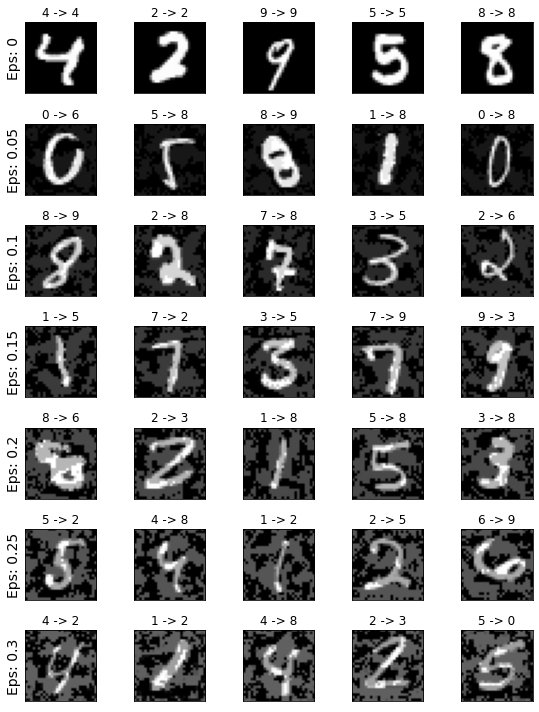

In [55]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig,adv,ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

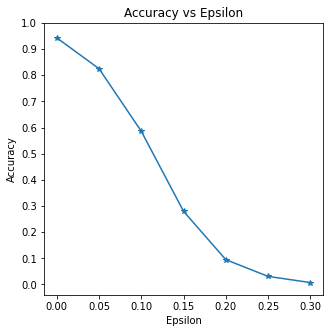

In [56]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()